# SARIMAX



A sigla SARIMAX significa **S**easonal **A**uto**R**egressive **I**ntegrated **M**oving-**A**verage with e**X**ogenous regressors, onde cada termo representa:

- **S** - Para sazonalidade, por exemplo, todo mês de dezembro ocorre um crescimento das vendas devido ao natal;
- **AR** - Utiliza os termos passados para explicar os futuros, os parâmetros são indicados pela letra grega $ \phi{} $;
- **I** - Diferencia a série para atender aos requisitos de estacionariedade;
- **MA** - Utiliza os erros passados para explicar os valores futuros, os parâmetros são indicados pela letra grega $ \theta{} $;
- **X** - Utiliza uma variável exógena para explicar a série. Exemplo, utilizar o risco país para explicar a cotação do dólar.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.graphics import tsaplots
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

A metodologia de Box–Jenkins aplica a metodologia ARMA e ARIMA para encontrar o melhor modelo para os valores realizados de uma série temporal. Segundo a Wikipédia consiste basicamente em:

 * **Identificação e seleção de modelo:** verificar se a série a ser modelada é estacionária, caso não seja, é necessário realizar a diferenciação. Verificar se existe autocorrelação e de qual ordem usando gráficos de funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para decidir qual (se houver) componente autorregressivo ou de média móvel deve ser usado no modelo;  
 

 * **Estimativa dos coeficientes do modelo:** usando algoritmos de computação para chegar aos coeficientes que melhor se ajustam ao modelo ARIMA selecionado (geralmente máxima verossimilhança);


  * **Verificar conformidade do modelo com as premissas:** Os resíduos devem ser independentes uns dos outros e constantes na média e na variância ao longo do tempo. Caso isso não ocorra, deve ser tentado outro modelo.

Como série para modelos ARIMA iremos utilizar o dataset "AirPassengers", ele está disponível no [Kaggle](https://www.kaggle.com/chirag19/air-passengers) e no pacote [datasets](https://www.rdocumentation.org/packages/datasets) do R com a função [AirPassengers](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/AirPassengers).

In [2]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month", inplace = True)
df = df.asfreq('MS')
df.columns = ["passengers"]
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df_ts = df["passengers"]

Text(0.5, 0, 'Data')

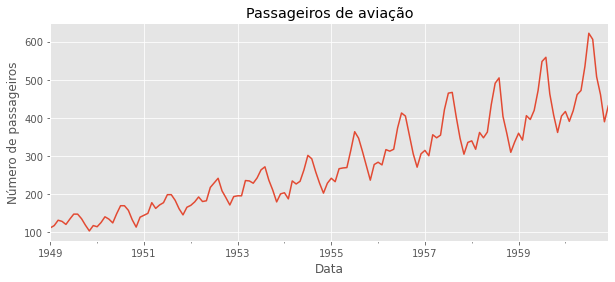

In [4]:
ax = df_ts.plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_ylabel("Número de passageiros")
ax.set_xlabel("Data")

## Estacionariedade

Apenas observando a série é possível verificar que a série não é estacionária, pois claramente está crescendo, não permanecendo num mesmo patamar.  

Para verificar a premissa da estacionariedade existem diversos testes estatísticos passíveis de uso, dentre eles:

+ [ADF (Augmented Dickey–Fuller)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test);
+ [Phillips–Perron](https://en.wikipedia.org/wiki/Phillips%E2%80%93Perron_test);
+ [KPSS (Kwiatkowski–Phillips–Schmidt–Shin)](https://en.wikipedia.org/wiki/KPSS_test);
+ [ADF-GLS](https://en.wikipedia.org/wiki/ADF-GLS_test).

Aqui usaremos o teste ADF, onde:

+ Hipótese nula ($H_0$): Presença de raiz unitária (série não estacionária);  
+ Hipótese alternativa ($H_1$): Não existe raiz unitária (série é estacionária).

In [5]:
print("P-Valor do ADF: {:.3f}".format(ts.adfuller(df_ts)[1]))

P-Valor do ADF: 0.992


A série é não estacionária, desta forma devemos diferenciar a série para realizar a estacionarização:

In [6]:
print("P-Valor do ADF de 1 diferenciação: {:.3f}".format(ts.adfuller(df_ts.diff(periods=1)[1:])[1]))

print("P-Valor do ADF de 2 diferenciação: {:.3f}".format(ts.adfuller(df_ts.diff(periods=2)[2:])[1]))

P-Valor do ADF de 1 diferenciação: 0.054
P-Valor do ADF de 2 diferenciação: 0.039


+ Mesmo com uma diferenciação utilizando uma significância de 0.05, ainda não passaríamos no teste, mas estamos muito próximo, logo tentaremos um modelo com diferenciação de primeira order, ou seja, ARIMA(x,1,x). Quanto mais diferenciações, mais difícil fica para entender a dinâmica da série.

Text(0.5, 0, 'Data')

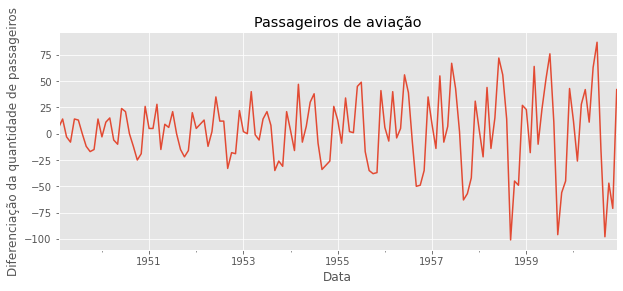

In [7]:
ax = df_ts.diff(periods=1)[1:].plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_ylabel("Diferenciação da quantidade de passageiros")
ax.set_xlabel("Data")

# Testes de autocorrelação

Agora iremos utilizar funções de autocorrelação (ACF) e autocorrelação parcial (PACF) para verificar a ordem das componentes autorregressivo e/ou de média móvel deve ser usado no modelo.

Para séries mais simples, puramente AR ou MA, esse reconhecimento é relativamente simples:
 + O termo AR deve ser calculado olhando qual é a última barrinha saindo do intervalo de confiança no teste de autocorrelação parcial, no caso abaixo seria 14. Existe uma liberdade para o modelador intervir em qual AR utilizar, como parar em 12 (já que os efeitos são anuais), zerar "na mão" os betas do coeficientes que estão dentro do intervalo de confiança, etc.  
 + Para o termo MA a ideia é a mesma, mas nesse caso olhando o teste de autocorrelação.

A vida realmente não é tão simples e [esta identificação](https://stats.stackexchange.com/questions/83322/arima-model-identification) não é trivial para séries não puramente AR ou MA. Nesse caso é recomendável algumas tentativas, ou seja, escolher um AR e MA e verificar a qualidade do modelo. Uma boa ferramenta é a função [auto.arima](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/auto.arima) do R, escrita pelo Rob J. Hyndman, que testa os modelos e escolhe o melhor segundo critérios de informação. O Python tem um [pacote pmdarima](https://github.com/alkaline-ml/pmdarima) que fornece uma função com a mesma funcionalidade, que será utilizada a seguir.

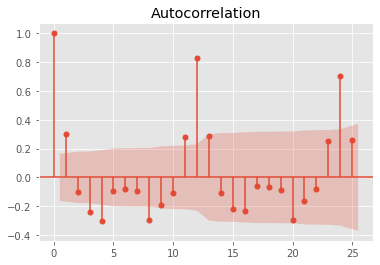

In [8]:
tsaplots.plot_acf(df_ts.diff(periods=1)[1:], lags = 25, alpha=.05, use_vlines=True);

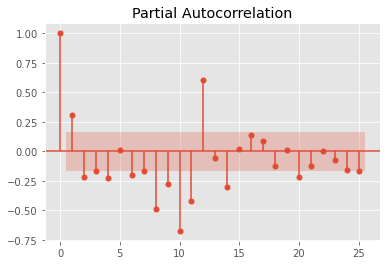

In [9]:
tsaplots.plot_pacf(df_ts.diff(periods=1)[1:], lags = 25, alpha=.05, use_vlines=True);

# Divisão dos dados em conjunto de Treinamento e Teste

Seria interessante dividir também um conjunto de validação, mas vamos simplificar.

In [10]:
X_train = df_ts[:"1958-12"]
X_test = df_ts["1959-01":]

In [11]:
predicoes_dict = dict()
modelos_dict = dict()

In [12]:
def plot_series(X_train, X_test, X_pred):
    fig, ax = plt.subplots(figsize=(18,4))

    ax.plot(X_train, label="Conjunto de treinamento")
    ax.plot(X_test, label="Conjunto de teste")
    ax.plot(X_pred, label="Predição", linestyle='dashed')

    ax.set_ylabel("Número de passageiros")
    ax.set_xlabel("Data")
    ax.set_title("Série Observada e Predição do Auto.Arima")
    ax.legend()

# Equação do ARMAX

Dedução da equação de um ARMAX (2,0,2). Segue:

$$ \hat{y}_{t-1} = c + \beta{} x_{t-1} + n_{t-1} $$

Isolando $ n_{t-1} $:

$$ n_{t-1} = \hat{y}_{t-1} - \beta{} x_{t-1} - c $$

Para $ n_{t-2} $:

$$ n_{t-2} = \hat{y}_{t-2} - \beta{} x_{t-2} - c $$

Substituindo nas equações da regressão com erros ARMA:

$$ \hat{y}_{t} = c + \beta{} x_t + n_t $$

$$ n_t = \phi{}_1 (\hat{y}_{t-1} - \beta{} x_{t-1} - c) + \phi{}_2 (\hat{y}_{t-2} - \beta{} x_{t-2} - c) - \theta{}_1 \varepsilon{}_{t-1} - \theta{}_2 \varepsilon{}_{t-2} $$

Juntando tudo:

$$ \hat{y}_{t} = c + \beta{} x_t + \phi{}_1 (\hat{y}_{t-1} - \beta{} x_{t-1} - c) + \phi{}_2 (\hat{y}_{t-2} - \beta{} x_{t-2} - c) - \theta{}_1 \varepsilon{}_{t-1} - \theta{}_2 \varepsilon{}_{t-2} $$


## Primeiro modelo ARIMA

Olhando os gráficos de autocorrelação e o teste ADF acima, utilizaremos um modelo ARIMA(12, 1, 1).

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
model = ARIMA(X_train, order=(12, 1, 1), trend = 'n')
model_fit = model.fit()
modelos_dict["ARIMA"] = model_fit
model_fit.summary()

C:\Users\ricar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ricar\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  120
Model:                ARIMA(12, 1, 1)   Log Likelihood                -450.601
Date:                Wed, 17 Feb 2021   AIC                            929.202
Time:                        17:06:03   BIC                            968.109
Sample:                    01-01-1949   HQIC                           945.001
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0629      0.095      0.664      0.507      -0.123       0.249
ar.L2         -0.0847      0.069     -1.232      0.218      -0.220       0.050
ar.L3          0.0261      0.061      0.427      0.669      -0.094       0.146
ar.L4         -0.0873      0.065     -1.334      0.182      -0.216       0.041
ar.L5          0.0552      0.070      0.789      0.430      -0.082       0.192
ar.L6         -0.0997      0.063     -1.591      0.112      -0.223       0.023
ar.L7          0.0226      0.076      0.299      0.765      -0.126       0.171
ar.L8         -0.1161      0.068     -1.708      0.088      -0.249       0.017
ar.L9          0.0218      0.076      0.289      0.773      -0.126       0.170
ar.L10        -0.1023      0.062     -1.643      0.100      -0.224       0.020
ar.L11         0.0663      0.072      0.920      0.358      -0.075       0.207
ar.L12         0.8313      0.068     12.239      0.000       0.698       0.964
ma.L1         -0.2836      0.157     -1.806      0.071      -0.591       0.024
sigma2        94.5602     14.572      6.489      0.000      66.000     123.121
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.76   Prob(JB):                         0.02
Heteroskedasticity (H):               2.65   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testes estatísticos

### Critérios de informação AIC e BIC

São métricas de qualidade do modelo, quanto menor melhor. A ideia é lidar com o trade-off entre a qualidade de ajuste do modelo e a quantidade de parâmetros do modelo. Em outras palavras, a AIC lida com o overfit e com o risco de underfit.

+ [AIC (Akaike Information Criterion)](https://en.wikipedia.org/wiki/Akaike_information_criterion);
+ [BIC (Bayesian Information Criterion)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).

In [15]:
print("AIC {:.2f}\nBIC {:.2f}".format(model_fit.aic, model_fit.bic))

AIC 929.20
BIC 968.11


### Teste de autocorrelação

Iremos utilizar o teste de Ljung–Box para autocorrelação, que pode ser encontrado na próxima biblioteca Statsmodels, sua documentação está [aqui](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html). As hipóteses de teste são:

+ Hipótese nula ($H_0$): Não existe correlação serial de ordem até "p" (que é escolhido por quem está utilizando o teste);  
+ Hipótese alternativa ($H_1$): Existe correlação serial de ao menos uma ordem até "p".

Desta maneira, não queremos descartar a hipótese nula, i.e., queremos um P-Valor maior do que 0,05.

In [16]:
lb_results = sm.stats.diagnostic.acorr_ljungbox(model_fit.resid.values, lags=1, return_df = True)

In [17]:
print("P-Valor do lag 1 do teste de Ljung-Box: {:.3f}".format(lb_results["lb_pvalue"].values[0]))

P-Valor do lag 1 do teste de Ljung-Box: 0.954


Não descartamos a hipótese nula, logo não deve existir autocorrelação serial de ordem até 1.

### Predição do modelo

Vamos verificar como se comporta a predição do modelo?

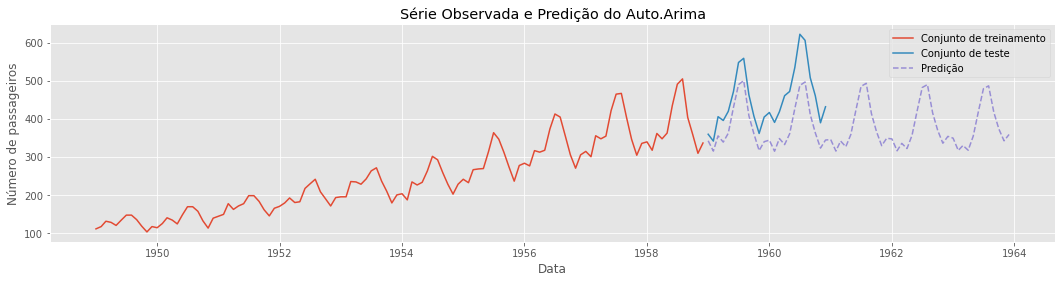

In [18]:
predicoes_dict["ARIMA"] = model_fit.forecast(steps=60)

plot_series(X_train, X_test, predicoes_dict["ARIMA"])

O parâmetro MA1 se mostrou significativo ou seja a coluna "P>|z|" é maior do que 0.05. Nem todos os parâmetros dos termos AR se mostraram significativos.

É possível ir zerando os parâmetros não significativos com a metodologia exemplificada abaixo, alguns autores sugerem essa abordagem, aqui apenas mostramos que é possível:

In [19]:
model = ARIMA(X_train, order=(12, 1, 1), trend = 'n', enforce_stationarity = False)
model_fit = model.fit_constrained({'ar.L3': 0., 'ar.L5': 0., 'ar.L7': 0.})
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  120
Model:                ARIMA(12, 1, 1)   Log Likelihood                -387.317
Date:                Wed, 17 Feb 2021   AIC                            796.633
Time:                        17:06:04   BIC                            826.034
Sample:                    01-01-1949   HQIC                           808.552
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.0290      0.048      0.599      0.549      -0.066       0.124
ar.L2            -0.0499      0.046     -1.077      0.282      -0.141       0.041
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4            -0.0441      0.052     -0.853      0.394      -0.145       0.057
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6            -0.0733      0.051     -1.450      0.147      -0.172       0.026
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8            -0.0886      0.054     -1.628      0.104      -0.195       0.018
ar.L9            -0.0385      0.051     -0.759      0.448      -0.138       0.061
ar.L10           -0.0674      0.055     -1.230      0.219      -0.175       0.040
ar.L11            0.0559      0.053      1.060      0.289      -0.047       0.159
ar.L12            1.0048      0.050     20.125      0.000       0.907       1.103
ma.L1            -0.3769      0.108     -3.478      0.001      -0.589      -0.165
sigma2           81.4766     11.242      7.248      0.000      59.443     103.510
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 1.30
Prob(Q):                              0.67   Prob(JB):                         0.52
Heteroskedasticity (H):               0.84   Skew:                             0.12
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelo SARIMA

Pela curva da autocorrelação parcial, o lag 12 apresenta uma forte correlação, no entanto, quando utilizamos um modelo AR12, com todos os parâmetros até o 12, o resultado foram vários parâmetros não significativos. Vamos tentar utilizar um modelo que agora o termo AR pode ser sazonal, ou seja, não necessariamente ao ponto passado, mas ao ponto do ano passado.

O SARIMA adiciona 4 novos índice, além do (p, d, q) do ARIMA, são adicionados os termos (P, D, Q, m), a notação pode passar a ser escrita da seguinte forma:

$$(p, d, q)x(P, D, Q, s)$$

In [20]:
model = ARIMA(X_train, order=(1, 1, 0), seasonal_order=(1, 0, 0, 12), trend = 'n')
model_fit = model.fit()
modelos_dict["SARIMA"] = model_fit
model_fit.summary()

C:\Users\ricar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       passengers   No. Observations:                  120
Model:             ARIMA(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -458.661
Date:                          Wed, 17 Feb 2021   AIC                            923.322
Time:                                  17:06:04   BIC                            931.659
Sample:                              01-01-1949   HQIC                           926.707
                                   - 12-01-1958                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1828      0.087     -2.097      0.036      -0.354      -0.012
ar.S.L12       0.9575      0.023     41.387      0.000       0.912       1.003
sigma2       101.4708     12.922      7.853      0.000      76.144     126.797
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.37
Prob(Q):                              0.93   Prob(JB):                         0.04
Heteroskedasticity (H):               2.85   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Como imaginado a utilização do ponto de 12 meses anterior, ou seja, AR sazonal de 12 meses, se mostrou significativo.

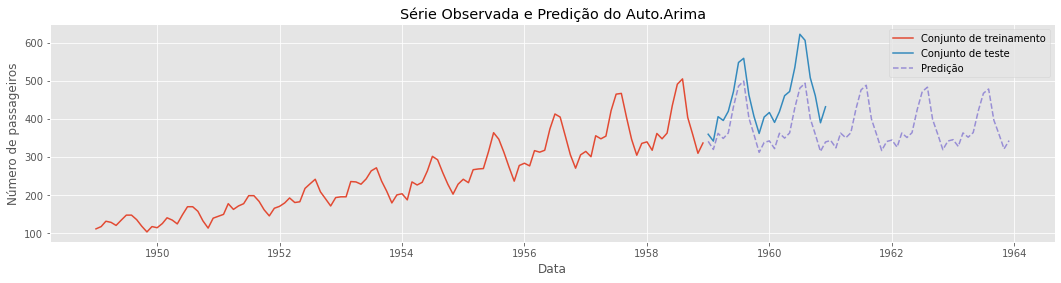

In [21]:
predicoes_dict["SARIMA"] = model_fit.forecast(steps=60)

plot_series(X_train, X_test, predicoes_dict["SARIMA"])

In [22]:
lb_results = sm.stats.diagnostic.acorr_ljungbox(model_fit.resid.values, lags=1, return_df = True)

In [23]:
print("P-Valor do lag 1 do teste de Ljung-Box: {:.3f}".format(lb_results["lb_pvalue"].values[0]))

P-Valor do lag 1 do teste de Ljung-Box: 0.589


# Auto.arima

O [auto.arima](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/auto.arima) é uma função do pacote Forecast do R escrita por Rob J. Hyndman, que visa estimar modelos ARIMA automaticamente, escolhendo o modelo com melhor critério de informação. Uma versão da função para o Python chamada pmdarima foi escrita por [Taylor G Smith](https://github.com/tgsmith61591), [repositório do Github](https://alkaline-ml.com/pmdarima/).

In [24]:
# Para instalar o pmdarima:
# !pip install pmdarima

In [25]:
import pmdarima as pm

In [26]:
model = pm.auto_arima(X_train, seasonal=True, m=12)
modelos_dict["auto.ARIMA"] = model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Wed, 17 Feb 2021   AIC                            808.863
Time:                                    17:06:09   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

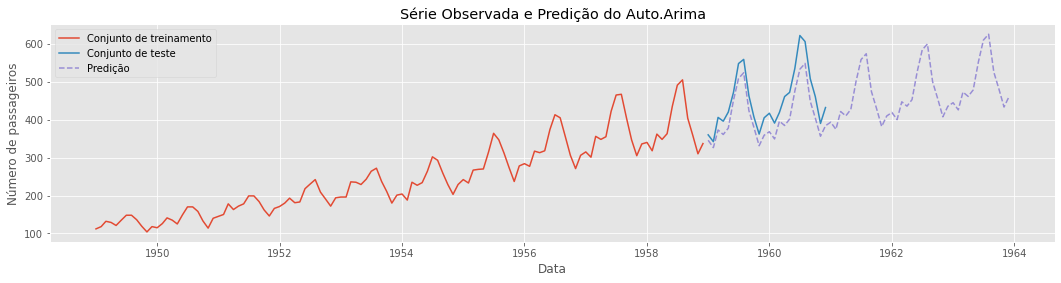

In [27]:
predicoes_dict["auto.ARIMA"] = pd.Series(model.predict(60), index =  pd.date_range(start = '1959-01-01', periods = 60, freq = 'MS'))


plot_series(X_train, X_test, predicoes_dict["auto.ARIMA"])

# SARIMAX

Como vimos acima, conseguimos modelar muito bem o "shape" da curva, com os picos e vales ao longo dos meses do ano, no entanto,  o patamar é mais difícil. Se formos pensar, durante o ano a maioria dos negócios, seja a aviação que é tema de nosso dataset, seja vendas de produtos no mercado, dentre outros, têm uma sazonalidade característica, mas quanto o setor vai crescer no ano seguinte é uma incógnita.

Geralmente atividade econômica (PIB) está correlacionada com o crescimento dos setores. Se o PIB cresce, o resto também cresce. Desta forma, o crescimento do PIB pode ser uma boa proxy. 

Para exemplificar, iremos utilizar a média móvel da série como uma proxy para o crescimento do PIB e utilizar como uma variável exógena, explicativa, do problema. Estamos claramente vazando informações para o conjunto de teste, além disso, para projetar a série, também precisamos da projeção dessa variável exógena, o que no caso do PIB geralmente não é problema, já que existem várias casas que fazem projeções públicas deste dado.

In [28]:
df_ts_MA12 = df_ts.rolling(12, min_periods = 1).mean()

# Repete o último ponto da média móvel por mais 3 anos, para termos uma projeção maior
df_ts_MA12 = pd.concat([df_ts_MA12, pd.DataFrame(index = pd.date_range(start = '1961-01-01', 
                                                          periods = 36, freq = 'MS'))], axis = 0)
df_ts_MA12.fillna(df_ts_MA12.loc["1960-12"].values[0][0], inplace = True)
df_ts_MA12.rename(columns = {0: "PIB"}, inplace = True)

Text(0.5, 1.0, 'Número de passageiros com média móvel 12')

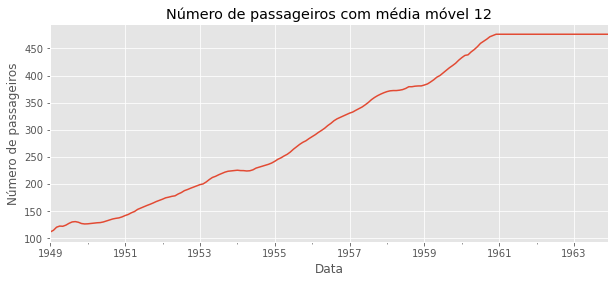

In [29]:
ax = df_ts_MA12.plot(figsize = (10,4), legend = False, grid = True, title = "Passageiros de aviação")
ax.set_xlabel("Data")
ax.set_ylabel("Número de passageiros")
ax.set_title("Número de passageiros com média móvel 12")

In [30]:
model = ARIMA(endog = X_train, exog = df_ts_MA12[:"1958-12"], order=(1, 0, 0), seasonal_order=(0, 1, 0, 12), trend = 'n')
model_fit = model.fit()
modelos_dict["SARIMAX"] = model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       passengers   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -395.110
Date:                          Wed, 17 Feb 2021   AIC                            796.219
Time:                                  17:06:09   BIC                            804.266
Sample:                              01-01-1949   HQIC                           799.482
                                   - 12-01-1958                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PIB            0.9778      0.109      8.991      0.000       0.765       1.191
ar.L1          0.7091      0.069     10.256      0.000       0.574       0.845
sigma2        87.5752     12.093      7.242      0.000      63.874     111.276
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.55   Prob(JB):                         0.95
Heteroskedasticity (H):               1.27   Skew:                             0.06
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

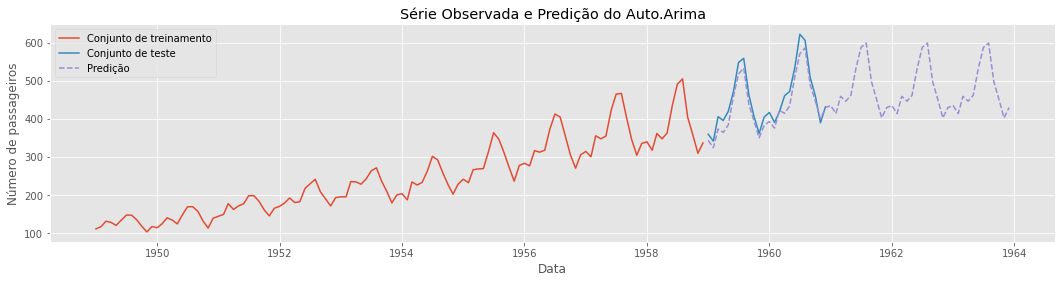

In [31]:
predicoes_dict["SARIMAX"] = model_fit.forecast(steps = 60, exog = df_ts_MA12["1959-01":])

plot_series(X_train, X_test, predicoes_dict["SARIMAX"])

In [32]:
lb_results = sm.stats.diagnostic.acorr_ljungbox(model_fit.resid.values, lags=1, return_df = True)

print("P-Valor do lag 1 do teste de Ljung-Box: {:.3f}".format(lb_results["lb_pvalue"].values[0]))

P-Valor do lag 1 do teste de Ljung-Box: 0.397


# Comparação de performance entre os métodos

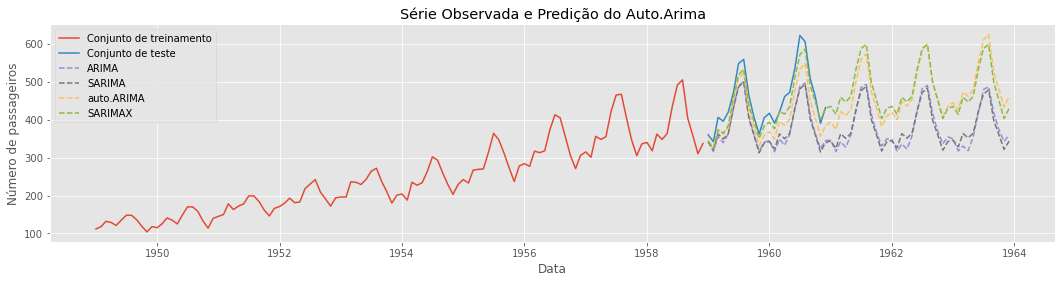

In [33]:
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(X_train, label = "Conjunto de treinamento")
ax.plot(X_test, label = "Conjunto de teste")

for modelo in predicoes_dict.keys():
    ax.plot(predicoes_dict[modelo], label = modelo, linestyle = 'dashed')
    
ax.set_ylabel("Número de passageiros")
ax.set_xlabel("Data")
ax.set_title("Série Observada e Predição do Auto.Arima")
ax.legend()

In [34]:
# https://stackoverflow.com/questions/47648133/mape-calculation-in-python

# Na versão utilizada do sklearn ainda não existia a função para cálculo do MAPE. Passou a existir na versão seguinte: 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [35]:
df_results = pd.DataFrame()

for modelo in predicoes_dict.keys():
    df_results.loc[modelo, "MAPE"] = mape_vectorized_v2(X_test, predicoes_dict[modelo][:"1960-12"])*100
    df_results.loc[modelo, "RMSE"] = np.sqrt(mean_squared_error(X_test, predicoes_dict[modelo][:"1960-12"]))
    if modelo != "auto.ARIMA":
        df_results.loc[modelo, "AIC"] = modelos_dict[modelo].aic
        df_results.loc[modelo, "BIC"] = modelos_dict[modelo].bic
    else:
        df_results.loc[modelo, "AIC"] = modelos_dict[modelo].aic()
        df_results.loc[modelo, "BIC"] = modelos_dict[modelo].bic()

df_results

,MAPE,RMSE,AIC,BIC
ARIMA,15.665714,78.204443,929.201742,968.109471
SARIMA,15.567375,78.277297,923.321824,931.659195
auto.ARIMA,9.439333,47.226394,808.862991,819.591516
SARIMAX,4.904896,25.453057,796.219437,804.265831


## Conclusões

O auto.arima se mostrou mais eficaz que o modeleiro, demonstrando que com cuidado pode ser uma excelente ferramenta para modelagem de séries temporais.

O uso de variáveis exógenas também se mostrou excelente, tendo uma grande melhora nas métricas. É importante aqui frisar que utilizamos a própria série suavizada como variável explicativa, então era evidente que existiria melhora. No mundo real é necessária a busca por variáveis que possuam correlação com a série a ser modelada, o que não é tão fácil.